In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import time as ts
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
# import opty_lib as op
# reload(op);

# q = me.dynamicsymbols('q1 q2 q3 q4 q5 q6')  # coordinates

# op.YZY_seq(*q[0:3])

In [3]:
# Equation of motion for 3D double pendulum ###

import sympy.physics.mechanics as me
import sympy as sp

t = sp.symbols('t')
q = me.dynamicsymbols('q1 q2 q3 q4 q5 q6')  # coordinates
u = me.dynamicsymbols('u1 u2 u3 u4 u5 u6')  # angular velocities
# l, m, g, Ixx, Iyy, Izz = sp.symbols('l m g Ixx Iyy Izz')  # 
l = 5
m = 10
g = 9.81
Ixx = 10
Iyy = 1
Izz = 5
F = me.dynamicsymbols('F1:7')

N = me.ReferenceFrame('frame_ground')
N0 = me.Point('point_ground')
N0.set_vel(N,0)

A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
frame = [A,B]
mA = me.Point('mA')
mB = me.Point('mB')
ABj = me.Point('ABj')
rot = []
rot1 = []

# rotate joint by quaternion and apply angular velocities
# first joint is in the world frame center
A.orient_body_fixed(N, q[0:3], rotation_order = 'YZY')
# rot.append(A.ang_vel_in(N))
# A.set_ang_vel(N, u[0]*A.x + u[1]*A.y + u[2]*A.z)
# rot1.append(A.ang_vel_in(N))

# set masscenter of the first body
mA.set_pos(N0, -l/2 * A.z)
mA.v2pt_theory(N0,N,A)
FG1 = [(mA, -m * g * N.z)]

# set the position of the joint between the two bodies
ABj.set_pos(N0, -l * A.z)
ABj.v2pt_theory(N0,N,A)

# orient second body from the first body
B.orient_body_fixed(A, q[3:6], rotation_order = 'YZY')
# rot.append(B.ang_vel_in(A))
# B.set_ang_vel(A, u[3]*A.x + u[4]*A.y + u[5]*A.z)
# rot1.append(B.ang_vel_in(A))

mB.set_pos(ABj, -l/2 * B.z)
mB.v2pt_theory(ABj,N,B)
I1 = me.inertia(A, Ixx, Iyy, Izz)
I2 = me.inertia(B, Ixx, Iyy, Izz)

BODY = []
BODY.append(me.RigidBody('Abody', mA, A, m, (I1, mA)))
BODY.append(me.RigidBody('Bbody', mB, B, m, (I2, mB)))

FG2 = [(mB, -m * g * N.z)]
Torque1 = [(A, 2000*(F[0]*A.x+F[1]*A.y+F[2]*A.z))]
Torque2 = [(B, 2000*(F[3]*B.x+F[4]*B.y+F[5]*B.z))]
kindeq = []
# for i in range(2):
#     for uv in frame[i]:
#         kindeq.append(me.dot(rot[i] - rot1[i], uv))
for i in range(6):
    kindeq.append([q[i].diff()-u[i]])


KM = me.KanesMethod(N, q_ind=q, u_ind=u, kd_eqs=kindeq)
(fr, frstar) = KM.kanes_equations(BODY, (FG1+FG2+Torque1+Torque2))

In [4]:
eoms = sp.Matrix(kindeq).col_join(fr+frstar)

In [5]:
duration = 1.5 # seconds
num_nodes = 101
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)
T = me.dynamicsymbols('T')

state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(F)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [6]:
import optyEngine as oe
reload (oe);
eul,deul = oe.create_trajectory(num_nodes,duration,interval_value)

In [7]:
eul_traj_guess = np.concatenate((eul,deul)).flatten()

In [8]:
w_traj = 10
w_vel = 1
w_force = 0.1
def obj(free):
    min_traj = w_traj * interval_value * np.sum((eul - free[:3*2*num_nodes])**2)
    min_vel = w_vel * interval_value * np.sum(free[3*2*num_nodes:6*2*num_nodes]**2)
    min_torque = w_force * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:3*2*num_nodes] = w_traj * 2.0 * interval_value * (free[:3*2*num_nodes] - eul)
    grad[3*2*num_nodes:6*2*num_nodes] = w_vel * 2 * interval_value * free[3*2*num_nodes:6*2*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = w_force * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [9]:

# # weight = [1.2,0.2,0.3,0.9,0.1,0.2]
# weight = np.ones(6)*100
# obj_torque = sum(sp.Matrix(F).applyfunc(lambda e: e**2))
# minQ1 = sp.Matrix([q[0]-(-sp.cos(np.pi)+1)*weight[0]])**2
# minQ2 = sp.Matrix([q[1]-(-sp.cos(np.pi)+1)*weight[1]])**2
# minQ3 = sp.Matrix([q[2]-(-sp.cos(np.pi)+1)*weight[2]])**2
# minQ4 = sp.Matrix([q[3]-(-sp.cos(np.pi)+1)*weight[3]])**2
# minQ5 = sp.Matrix([q[4]-(-sp.cos(np.pi)+1)*weight[4]])**2
# minQ6 = sp.Matrix([q[5]-(-sp.cos(np.pi)+1)*weight[5]])**2
# minQ = sum(minQ1+minQ2+minQ3+minQ4+minQ5+minQ6)

# obj_func = sp.Integral(obj_torque+minQ,t)
# obj, obj_grad = create_objective_function(obj_func,
#                                           (state_symbols),
#                                           specified_symbols,
#                                           tuple(),
#                                           num_nodes,
#                                           interval_value,
#                                           time_symbol=t)
# obj_func

In [10]:
instance_constraints = [
    # q[0].func(0.0) - 0,
    # # q[1].func(0.0) - 0,
    # q[2].func(0.0) - 0,
    # q[3].func(0.0) - 0,
    # # q[4].func(0.0) - 0,
    # q[5].func(0.0) - 0,
    # u[0].func(0.0) - 0,
    # u[1].func(0.0) - 0,
    # u[2].func(0.0) - 0,
    # u[3].func(0.0) - 0,
    # u[4].func(0.0) - 0,
    u[5].func(0.0) - 0,
]
instance_constraints = tuple(instance_constraints)

max_force = 50000.0
bounds = {
    F[0]: (-max_force, max_force),
    F[1]: (-max_force, max_force),
    F[2]: (-max_force, max_force),
    F[3]: (-max_force, max_force),
    F[4]: (-max_force, max_force),
    F[5]: (-max_force, max_force),
}

In [11]:
start = ts.time()

prob = Problem(obj, obj_grad, eoms, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds={},
               time_symbol=t,
               integration_method='midpoint',
)

# prob.add_option('nlp_scaling_method', 'gradient-based')

time_to_create = ts.time() - start
print(time_to_create)

10.974457263946533


In [12]:
initial_guess = np.random.randn(prob.num_free)*0
initial_guess[:6*2*num_nodes] = eul_traj_guess
prob.add_option('max_iter',10000)

In [13]:
start = ts.time()

solution, info = prob.solve(initial_guess)

time_to_create = ts.time() - start
print(time_to_create)

print(info['status_msg'])
print(info['obj_val'])

0.9308652877807617
b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'
0.7917666225270591


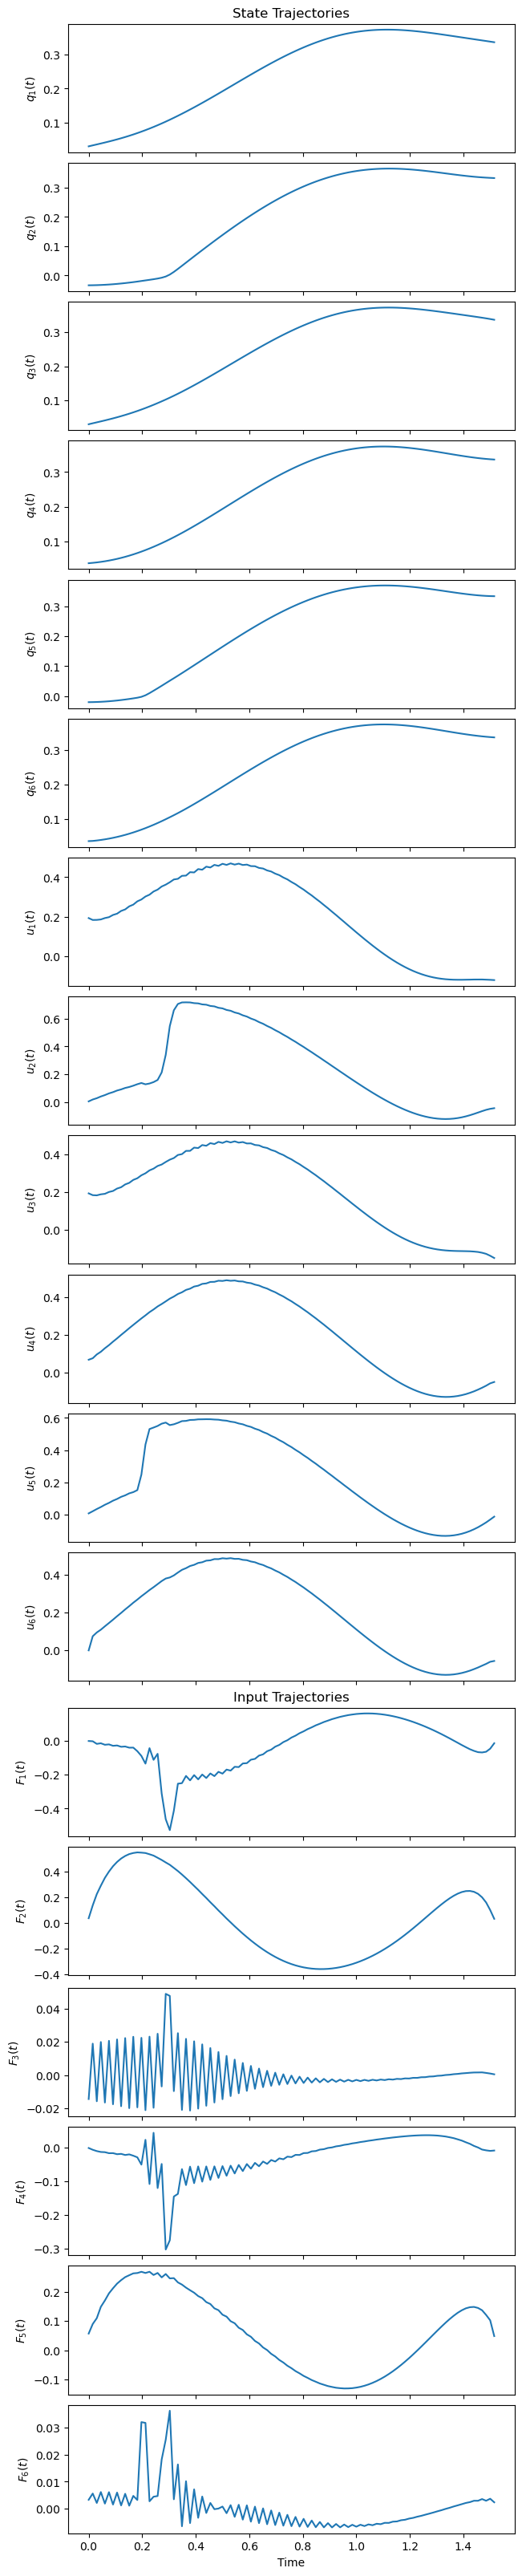

In [14]:
fig, axes = plt.subplots(18, 1, sharex=True,
                         figsize=(6.4, 0.8*40),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

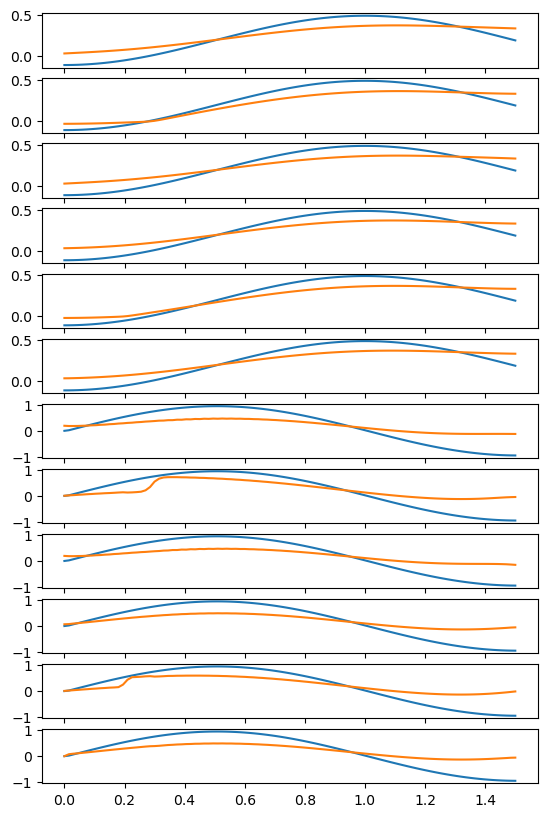

In [15]:
fig, axs = plt.subplots(12)
for j in range(12):
    axs[j].plot(time,eul_traj_guess[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [16]:
solution[1*num_nodes:2*num_nodes]

array([-0.03326092, -0.03307456, -0.03271768, -0.03219812, -0.03151109,
       -0.03065794, -0.02964604, -0.02847971, -0.02716645, -0.02571475,
       -0.02413291, -0.02242963, -0.02057675, -0.01857856, -0.01658588,
       -0.01462066, -0.01253618, -0.01026061, -0.00746539, -0.00331892,
        0.00331892,  0.012352  ,  0.02257614,  0.03322358,  0.04395881,
        0.05469369,  0.06538527,  0.07602543,  0.08659796,  0.09709897,
        0.1075169 ,  0.11784533,  0.1280747 ,  0.13819604,  0.148201  ,
        0.15807882,  0.16782191,  0.17741851,  0.18686145,  0.19613859,
        0.20524301,  0.21416272,  0.22289097,  0.23141625,  0.23973203,
        0.24782753,  0.25569651,  0.26332913,  0.27071951,  0.27785888,
        0.28474188,  0.29136088,  0.29771119,  0.30378636,  0.3095825 ,
        0.31509442,  0.32031911,  0.32525271,  0.32989321,  0.33423808,
        0.33828644,  0.34203712,  0.34549045,  0.34864667,  0.3515074 ,
        0.35407432,  0.35635041,  0.35833887,  0.36004408,  0.36